# Equilibrium Binding of Transcription Factors
> If you know TF concentrations, binding site affinities, and cooperativities, can you predict probabilities for each configuration?

- toc: true
- comments: true
- hide: false

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.colors import colorConverter
# colorConverter.to_rgba('mediumseagreen', alpha=.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['hatch.linewidth'] = 0.3

## Background & Motivation

At the moment, there does not exist an assay which reports directly on the occupancies of transcription factor binding sites across the genome in single cells. However, we can measure chromatin accessibility in single cells via [single-cell ATAC-seq](https://www.10xgenomics.com/products/single-cell-atac), which reports a 1-dimensional projection of TFBS occupancies. This blog post explores an approach to lift single cell ATAC signals onto the space of TFBS occupancies, i.e. to deconvolve ATAC signals into TF binding tracks. 

Our approach relies on an orthogonal suite of experiments characterizing transcription factor binding in vitro. In [High-Throughput SELEX](https://genome.cshlp.org/content/20/6/861.long) experiments, the 

## Equilibrium Binding Model

There exist two mathematical formalisms to describe the probabilities of molecular configurations at equilibrium: thermodynamics and kinetics. The kinetics formalism is more general: it describes a system's trajectory to equilibrium, and can describe non-equilibrium systems. Tthe thermodynamics formalism only describes equilibrium, but requires fewer parameters to do so. We'll derive an expression for the probability of a single TFBS' occupancy with both formalisms, but drop the kinetic description for more elaborate configurations. 

### Single TF

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}$$

Most derivations of the probability of TFBS occupancy at equilibrium employ a kinetics formalism, so we'll walk through that first, and then explore the analog in the thermodynamics description. In the kinetic description, the parameters are **rates**. 

$$ \mathrm{TF} + \mathrm{TFBS} \underset{\koff}{\overset{\kon}{\rightleftarrows}} \mathrm{TF\colon TFBS} $$

> Note: We will assume the [Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action) for well-mixed solutions throughout. 

The natural rates are the rate of TF binding $\kon$ and unbinding $\koff$. Equilibrium is reached when binding and unbinding are balanced:

$$\frac{d[\mathrm{TF\colon TFBS}]}{dt} = k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}] - k_{\mathrm{off}}[\mathrm{TF\colon TFBS}] = 0 \text{ at equilibrium}$$
$$k_{\mathrm{on}}[\mathrm{TF}]_{\mathrm{eq}}[\mathrm{TFBS}]_{\mathrm{eq}} = k_{\mathrm{off}}[\mathrm{TF\colon TFBS}]_{\mathrm{eq}}$$
$$\text{(dropping eq subscript) }[\mathrm{TF\colon TFBS}] = \frac{k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}]}{k_{\mathrm{off}}} = \frac{[\mathrm{TF}][\mathrm{TFBS}]}{k_{d}}$$

where $k_{d} = \frac{\koff}{\kon}$ is called the [dissociation constant](https://en.wikipedia.org/wiki/Dissociation_constant) (or equilibrium constant). We'd like to determine the probability of finding the TFBS occupied, i.e. the fraction of time it spends in the bound state. That fraction is $\frac{[\mathrm{bound}]}{([\mathrm{unbound}] + [\mathrm{bound}])} = \frac{[\mathrm{TF\colon TFBS}]}{([\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}])}$. Define the denominator as $[\mathrm{TFBS}]_{0} = [\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}]$ so that $[\mathrm{TFBS}] = [\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}]$ and substitute: 

$$[\mathrm{TF\colon TFBS}] = \frac{[\mathrm{TF}]([\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}])}{k_{d}}$$
$$[\mathrm{TF\colon TFBS}](k_d + [\mathrm{TF}]) = [\mathrm{TF}][\mathrm{TFBS}]_{0}$$
$$\frac{[\mathrm{TF\colon TFBS}]}{[\mathrm{TFBS}]_{0}} = \frac{[\mathrm{TF}]}{k_d + [\mathrm{TF}]}$$

> Note: We could also ask for this expression in terms of $[\mathrm{TF}]_0 = [\mathrm{TF}] + [\mathrm{TF\colon TFBS}]$ however, since we're considering a single TFBS, $[\mathrm{TF\colon TFBS}]$ is at most 1, and so $[\mathrm{TF}]_0 \approx [\mathrm{TF}]$. In instances of ligand-receptor binding in which that approximation cannot be made, the fraction bound is a messy quadratic. [Derivation here](https://www.med.upenn.edu/ostaplab/assets/user-content/documents/simpleligandbindingequations.pdf). 

In the thermodynamic description, the parameters are Gibbs free energies $\Delta G$. Let's follow the derivation from [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/) (pp. 242) and consider the number microstates underlying each of the of bound and unbound macrostates, and their energies.

In order to count microstates, we imagine distributing $L$ TF molecules across a space-filling lattice with $\Omega$ sites. The energy of a TF in solution is $\varepsilon_{\mathrm{solution}}$ and the energy of a bound TF is $\varepsilon_{\mathrm{bound}}$. $\beta$ is the constant $1/k_b T$ where $k_b$ is Boltzmann's constant and $T$ is the temperature. 

<img src="../data/equilibrium_TFs/single_TF_thermodynamic.png" width=1200/>

In our case, the number of microstates in the unbound macrostate is $\frac{\Omega !}{L!(\Omega -L)!}\approx \frac{\Omega^L}{L!}$ and they each have energy $L \cdot \varepsilon_s$. The number of microstates in the bound macrostate is $\frac{\Omega !}{(L-1)!(\Omega -(L+1))}\approx \frac{\Omega^{(L-1)}}{(L-1)!}$ and they each have energy $(L-1) \varepsilon_s + \varepsilon_b$.

The [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) describes the probability of a microstate as a function of its energy: $p(E_i) = e^{-\beta E_i}/Z$ where $Z$ is the "partition function" or simply $\sum_i e^{-\beta E_i}$ the sum of the weights of the microstates, which normalizes the distribution. In our case:


$$Z(L,\Omega)=\left(\colorbox{LightCyan}{$ \frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$}\right) + \left(\colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}\right)$$

With that expression in hand, we can express the probability of the bound macrostate, $p_b$:

$$p_b=\frac{ \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}}{\colorbox{LightCyan}{$\frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$} + \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}} \cdot \color{DarkRed}\frac{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}}{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}} \color{black} = \frac{(L/\Omega)e^{- \beta \Delta \varepsilon}}{1+(L/\Omega)e^{- \beta \Delta \varepsilon}}  $$

Where we have defined $\Delta \varepsilon = \varepsilon_b - \varepsilon_s$. $L/\Omega$ is really just the concentration $[\mathrm{TF}]$, which leaves us with an expression suspiciously similar to the one we derived from the kinetics formalism:

$$p_b = \frac{[\mathrm{TF}]e^{-\beta \Delta \varepsilon}}{1+[\mathrm{TF}]e^{-\beta \Delta \varepsilon}} \cdot \color{DarkRed}\frac{e^{\beta \Delta \varepsilon}}{e^{\beta \Delta \varepsilon}} \color{black} = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$$

From which we recapitulate an important correspondence between kinetics and thermodynamics at equilibrium: $ k_d = e^{\beta \Delta \varepsilon} = e^{\Delta \varepsilon / k_bT} $ more commonly written for different units as $k = e^{-\Delta G / RT}$.

The takeaway is that both the kinetic and thermodynamic formalisms produce an equivalent expression for the probability of each configuration, parameterized respectively by $k_d$ and $\Delta G$.

**References**: 
- [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/)
- [Thermodynamics of Biological Processes](https://doi.org/10.1016/B978-0-12-381268-1.00014-8)
- [Statistical Mechanics of Binding](http://www.bio-physics.at/wiki/index.php?title=Statistical_Mechanics_of_Binding)

### Direct Cooperativity

### Indirect cooperativity

### Competitive TF binding

### Putting it all together

In [2]:
TFBSs = [{'name':'A','start':10,'end':18,'dG':100},
         {'name':'B','start':22,'end':30,'dG':100}]

TF_concs = {'A': 100, 'B': 100}

In [3]:
# P(bound) = ([A]*e^-β*Δe) / (1 + [A]*e^-β*Δe)

In [7]:
# want a function which takes [TF] concentrations and TF binding sites and tells you the probability of each configuation

def enumerate_configs(TFBSs):
    pass

def Z(TFBSs, TF_concs):

    return [P_config(config) for config in enumerate_configs(TFBSs)]

def P_config(config):

    return multiplicity(config, TF_concs) * exp(-energy(TFBSs, TF_concs)/kbT)


def energy(TFBSs, TF_concs):
    pass
    # energy of binding of each occupied TFBS
    # energy of cooperativity between each bound TFBS
    # energy of competition between each bound TFBS
    # energy of competition between each bound TFBS and the nucleosome
    # energy of every unbound TF in solution


def multiplicity(TFBSs, TF_concs):
    pass




In [8]:
# I want an expression for the statistical weight of a configuration

# supposing I have concentrations rather than molecule counts, what is the continuum limit of the energy expressions?

In [9]:
# config is a list of [0, 1] floats, indexing into TFBSs. It's associated with a probability

# TFBSs is a list of structs with fields 'TF_name', 'pos_start', 'pos_end', 'dG'

# we also need a way to start nucleosome positions

In [17]:

config = [1., 1.]
TFs = list(TF_concs.keys())
genomic_range = [0, 50]
df = pd.DataFrame(TFBSs)

In [58]:
def c(TF_name):
    return {'A': 'blue', 'B': 'orange'}[TF_name]

In [122]:
def draw_config(TFBSs, config):

    plt.rcParams['figure.figsize'] = [12, int(np.log2(len(TFs)))]

    fig, ax = plt.subplots()

    ax.scatter(df.start.values, df.name.values,  alpha=0)
    ax.set(ylabel='TFs', yticks=range(len(TFs)), yticklabels=TFs, ylim=[-1, len(TFs)+1], xlabel='Genome', xlim=genomic_range)

    errorboxes = []

    for i, tfbs in enumerate(TFBSs):
        ax.add_patch(Rectangle((tfbs['start'], i), tfbs['end']-tfbs['start'], 0.9, fc=c(tfbs['name']), alpha=0.05))
        ax.add_patch(Rectangle((tfbs['start'], i), tfbs['end']-tfbs['start'], 0.1, fc=c(tfbs['name']), alpha=1))

    ax.grid(axis='y', lw=0.1)
    for side in ["right","top","left","bottom"]: ax.spines[side].set_visible(False)

    return ax

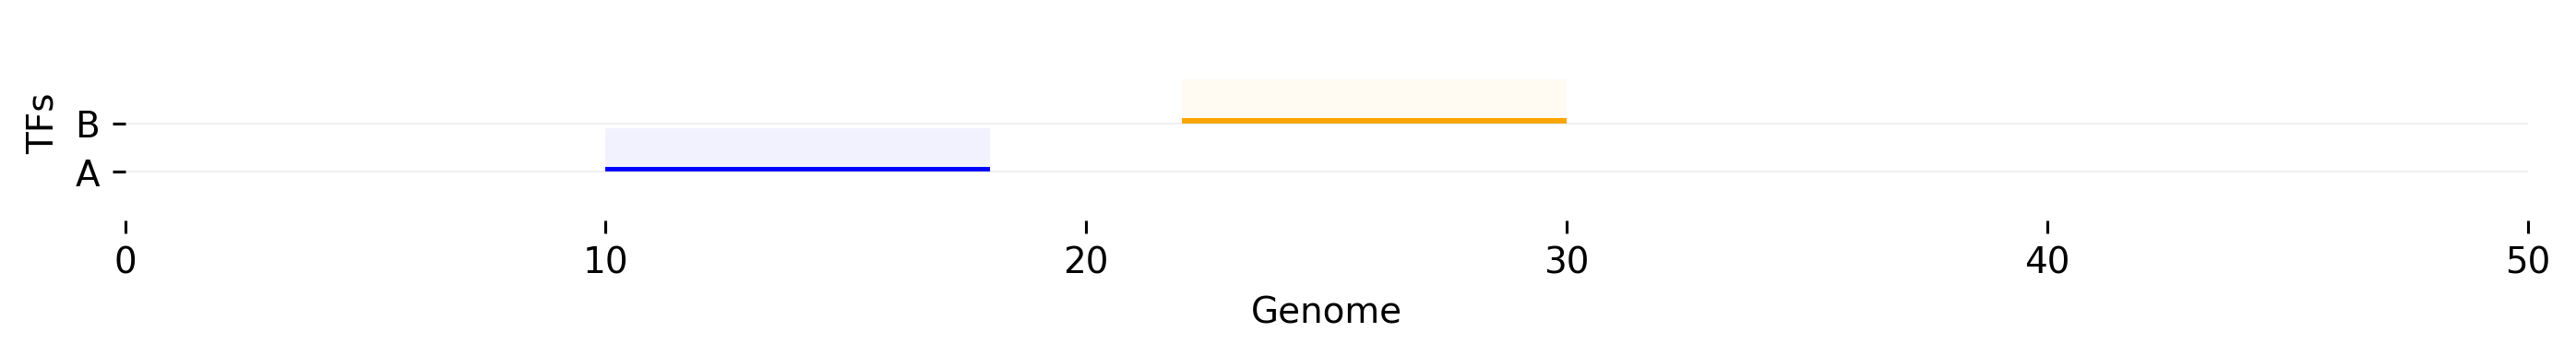

In [123]:
ax = draw_config(TFBSs, config)

## Conditioning on ATAC